# Synthetic Examples

Synthetic examples comparing different architectures using the low-level API of Ladder.

## Imports

In [1]:
import torch, pyro, os, re, sys, warnings
import torch.utils.data as utils
import numpy as np
import pandas as pd
from ladder.models import SCVI, SCANVI, Patches, _broadcast_inputs
from ladder.scripts import train_pyro, train_pyro_disjoint_param, get_device, get_reproduction_error

from sklearn.datasets import make_swiss_roll
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import math
import anndata as ad
import scanpy as sc

np.random.seed(42)
torch.manual_seed(42)
pyro.util.set_rng_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gamma_apr = np.round((1.-math.gamma(1+1.e-8))*1.e14 )*1.e-6

#device="cpu"

reducer = umap.UMAP(metric="euclidean", random_state=42, n_neighbors=40, min_dist=0.1)
warnings.filterwarnings('ignore')


print(f"Device: {device}")

Device: cuda


## Toy Dataset - Gaussians

Synthetic dataset where attributes are sampled from multivariate normals with different means

In [2]:
# Helpers for basic plots
def _transform_labels(labels):
    return torch.hstack((labels[:,:2].argmax(-1).view(-1,1), labels[:,2:].argmax(-1).view(-1,1)))

def get_labels(labels):
    labs = _transform_labels(labels)
    df = pd.DataFrame(labs)
    df["comb"] = df.apply(lambda x : str(x[0]) + "," + str(x[1]), axis = 1)
    return torch.tensor(pd.get_dummies(df["comb"]).astype(int).to_numpy())


#################### DATASET PARAMS #########################################################################################
n=2000  # Number of points in each attribute combination
batch_size=64 # Loader batch size
z_dim, w_dim=10, 10  # Latent dims of attributes and half dim of outputs
z_mean, z_std=0, 1  # Common latent parameters (gaussian)
a_10_mean, a_10_std, a_11_mean, a_11_std=0, 1, -1.15, 1  # Attribute 1 parameters: a10 --> Attribute 1 Off //  a11 --> Attribute 1 On // Parameters for respective gaussians
a_20_mean, a_20_std, a_21_mean, a_21_std=0, 1, 1.15, 1  # Attribute 2 parameters: a20 --> Attribute 2 Off // a21 --> Attribute 2 On // Parameters for respective gaussians
##################################################################################################################################

# Generate dataset
## Common
z_s = torch.normal(z_mean, z_std, size=(n*4, z_dim))


## Specific
w_0_0 = torch.concat((torch.normal(a_10_mean, a_10_std, size=(n, w_dim)), torch.normal(a_20_mean, a_20_std, size=(n, w_dim))), dim=-1)
w_0_1 = torch.concat((torch.normal(a_10_mean, a_10_std, size=(n, w_dim)), torch.normal(a_21_mean, a_21_std, size=(n, w_dim))), dim=-1)
w_1_0 = torch.concat((torch.normal(a_11_mean, a_11_std, size=(n, w_dim)), torch.normal(a_20_mean, a_20_std, size=(n, w_dim))), dim=-1)
w_1_1 = torch.concat((torch.normal(a_11_mean, a_11_std, size=(n, w_dim)), torch.normal(a_21_mean, a_21_std, size=(n, w_dim))), dim=-1)

## Combine Ws
w_s = torch.concat((w_0_0, w_0_1, w_1_0, w_1_1))

## Combine into full latents
data = torch.concat((z_s, w_s), dim=-1)

## Shift for non-negativity
data = data - data.min() + 1e-6

## Label Setup
labels = torch.concat((torch.tensor([1,0,1,0]).repeat((n,1)), torch.tensor([1,0,0,1]).repeat((n,1)), torch.tensor([0,1,1,0]).repeat((n,1)), torch.tensor([0,1,0,1]).repeat((n,1))))
labels_one_hot = torch.concat((torch.tensor([1,0,0,0]).repeat((n,1)), torch.tensor([0,1,0,0]).repeat((n,1)), torch.tensor([0,0,1,0]).repeat((n,1)), torch.tensor([0,0,0,1]).repeat((n,1))))


# Datasets & Loaders Setup
dataset = utils.TensorDataset(data.double(), labels.double(), labels.double())
dataset_one_hot = utils.TensorDataset(data.double(), labels_one_hot.double(), labels.double())
train_set, test_set = utils.random_split(dataset, [0.8, 0.2])
train_set_oh, test_set_oh = utils.random_split(dataset_one_hot, [0.8, 0.2])
train_loader, test_loader = utils.DataLoader(train_set, num_workers=4, batch_size=batch_size, shuffle=True), utils.DataLoader(test_set, num_workers=4, batch_size=batch_size, shuffle=False)
train_loader_oh, test_loader_oh = utils.DataLoader(train_set_oh, num_workers=4, batch_size=batch_size, shuffle=True), utils.DataLoader(test_set_oh, num_workers=4, batch_size=batch_size, shuffle=False)

run = 'gaussians'

## Dataset Visualization

Visually understanding the dataset generated in the previous step.

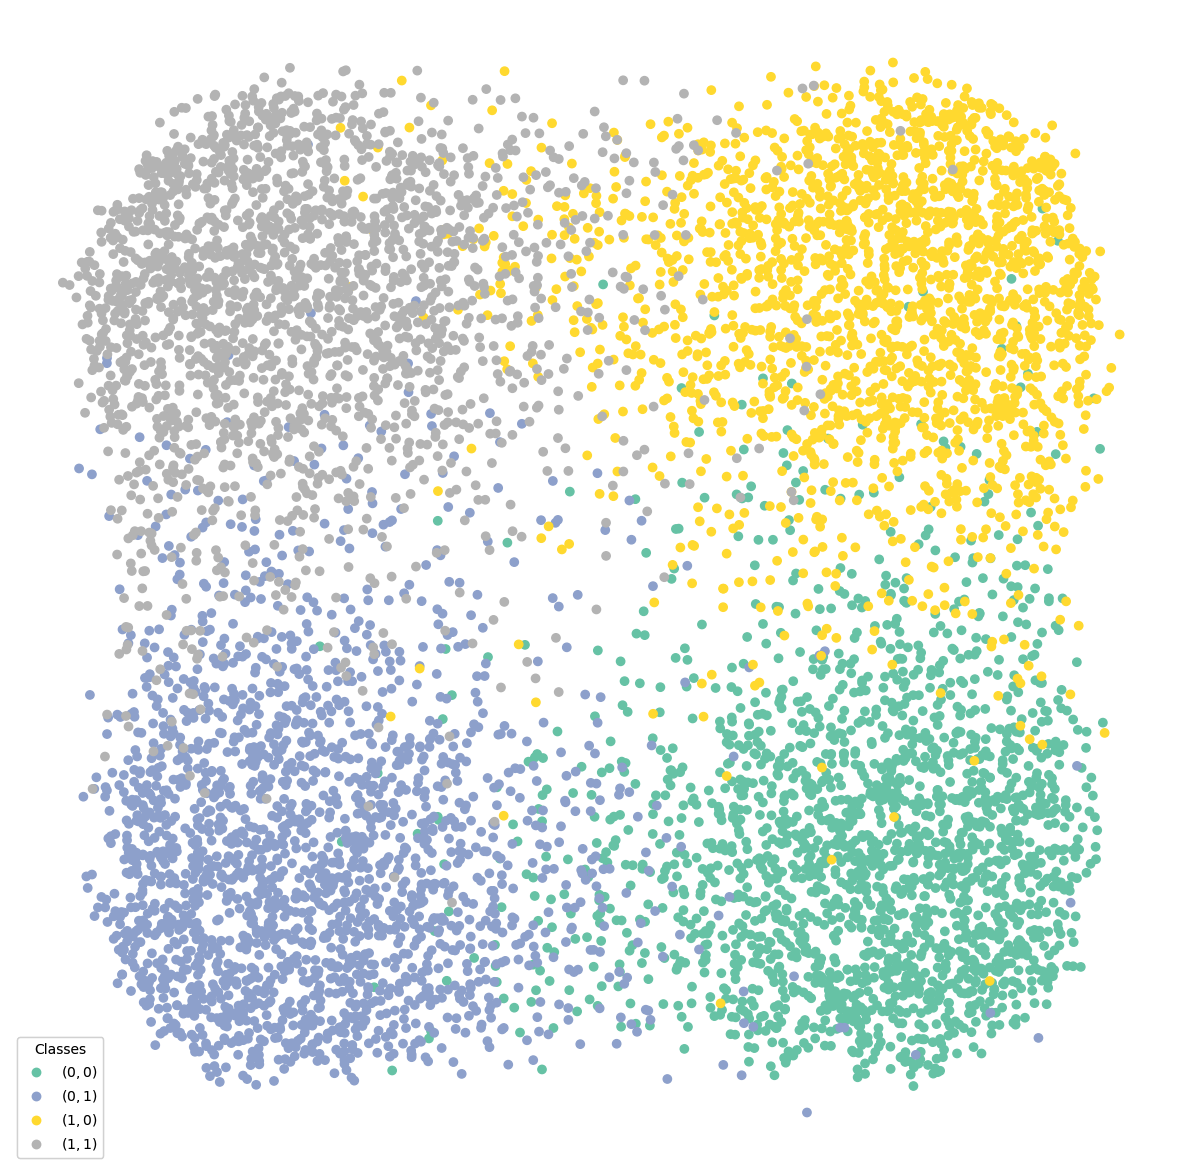

In [3]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
data_umap = reducer.fit_transform(dataset[:][0])
scatter = ax.scatter(data_umap[:, 0], data_umap[:, 1], c=np.array(get_labels(dataset[:][2]).argmax(-1)), cmap="Set2")
elems = list(scatter.legend_elements())
elems[1] = ['$\\mathdefault{(0,0)}$',
 '$\\mathdefault{(0,1)}$',
 '$\\mathdefault{(1,0)}$',
 '$\\mathdefault{(1,1)}$']
legend = ax.legend(*elems,
                    loc="lower left", title="Classes")
ax.add_artist(legend)
ax.axis('off')



plt.show()

## Model

In [4]:
l_mean, l_scale = train_set[:][0].sum(-1).log().mean(), train_set[:][0].sum(-1).log().var()  #Ignored but needed for params
len_attrs = [2,2]

pyro.clear_param_store()

patches = Patches(
    num_genes=train_set[0][0].shape[0],
    num_labels=sum(len_attrs),
    l_loc=l_mean,
    l_scale=l_scale,
    len_attrs=len_attrs, betas = [50, 50],
    scale_factor=1.0 / (batch_size * train_set[0][0].shape[0]), 
    batch_correction=False, 
    reconstruction='Normal',
    recon_weight=20,
    ).double()

patches, train_loss, test_loss, param_nonc_names, param_c_names =\
train_pyro_disjoint_param(patches, 
                          train_loader=train_loader, 
                          test_loader=test_loader, 
                          verbose=True, 
                          num_epochs=250,
                          convergence_window=150,
                          optim_args={
                            "optim_args": {"lr": 1e-4, "eps": 1e-2, "betas": (0.9, 0.999)},
                            "gamma": 1e-2,
                            "milestones": [],
                          },)

Using device: cuda

Epoch : 0 || Train Loss: 525.73456 // 70.78263 || Test Loss: 365.53618 // 70.1135 || Warmup : False
Epoch : 1 || Train Loss: 282.90124 // 70.11191 || Test Loss: 234.17772 // 69.91465 || Warmup : False
Epoch : 2 || Train Loss: 189.43538 // 70.03751 || Test Loss: 163.94181 // 70.0846 || Warmup : False
Epoch : 3 || Train Loss: 140.57234 // 69.93311 || Test Loss: 127.98266 // 69.70905 || Warmup : False
Epoch : 4 || Train Loss: 111.71592 // 69.70979 || Test Loss: 104.4257 // 69.47301 || Warmup : False
Epoch : 5 || Train Loss: 93.24119 // 69.80638 || Test Loss: 87.18071 // 69.96882 || Warmup : False
Epoch : 6 || Train Loss: 80.33448 // 69.70966 || Test Loss: 75.66276 // 69.66675 || Warmup : False
Epoch : 7 || Train Loss: 71.02782 // 69.79988 || Test Loss: 67.60903 // 69.83654 || Warmup : False
Epoch : 8 || Train Loss: 64.16231 // 69.6864 || Test Loss: 62.27764 // 69.64961 || Warmup : False
Epoch : 9 || Train Loss: 58.89623 // 69.69152 || Test Loss: 56.89816 // 69.62544 ||

## Evaluation Metrics

In [5]:
patches = patches.cpu()
patches.eval()
predictive = pyro.infer.Predictive(patches.generate, num_samples=1)

for metric in ["rmse", "corr", "swd", "chamfer"]:
    preds_mean_error, _, preds, profiles = get_reproduction_error(test_set, predictive, metric=metric, n_trials=10, verbose=True, use_cuda=False)
    print(f"{metric} : {np.round(preds_mean_error, 3)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.68it/s]


rmse : 2.476


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.69it/s]


corr : 0.996


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.93it/s]


swd : 0.09


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3953.53it/s]

chamfer : 0.91


## Reconstruction

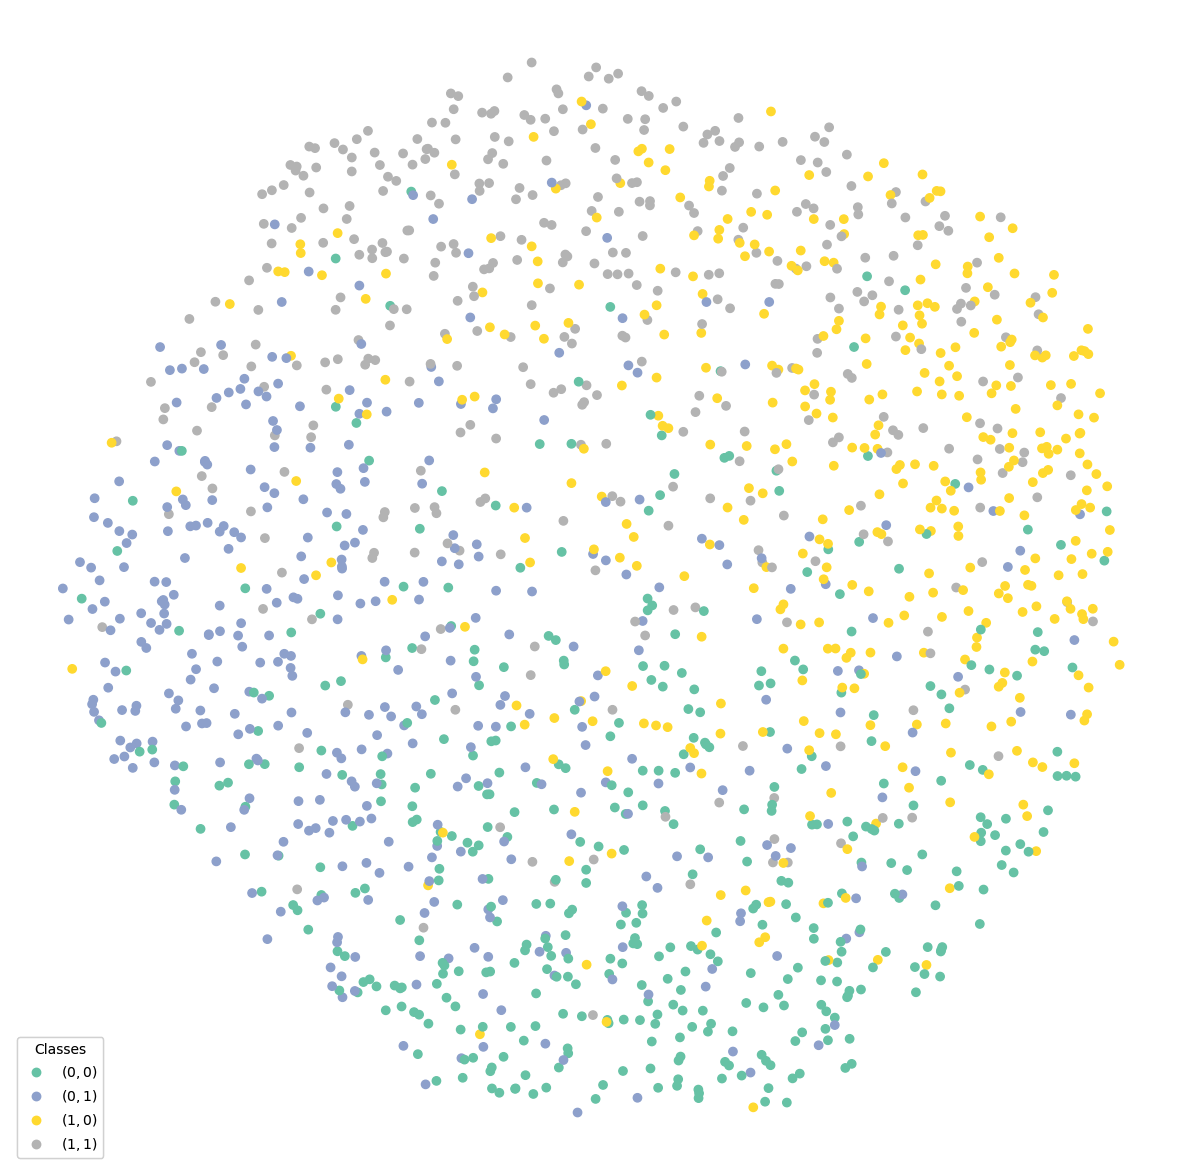

In [6]:
dat_t = predictive(test_set[:][0], test_set[:][1], test_set[:][1])["x"]
data_umap = reducer.fit_transform(dat_t[0])

fig, ax = plt.subplots(1,1,figsize=(15,15))

scatter = ax.scatter(data_umap[:, 0], data_umap[:, 1], c=np.array(get_labels(test_set[:][1]).argmax(-1)), cmap="Set2")


elems = list(scatter.legend_elements())
elems[1] = ['$\\mathdefault{(0,0)}$',
 '$\\mathdefault{(0,1)}$',
 '$\\mathdefault{(1,0)}$',
 '$\\mathdefault{(1,1)}$']

legend = ax.legend(*elems,
                    loc="lower left", title="Classes")

ax.add_artist(legend)

ax.axis('off')

#plt.savefig("test_recon_umap_synthetic.png", dpi=300, bbox_inches="tight")

plt.show()

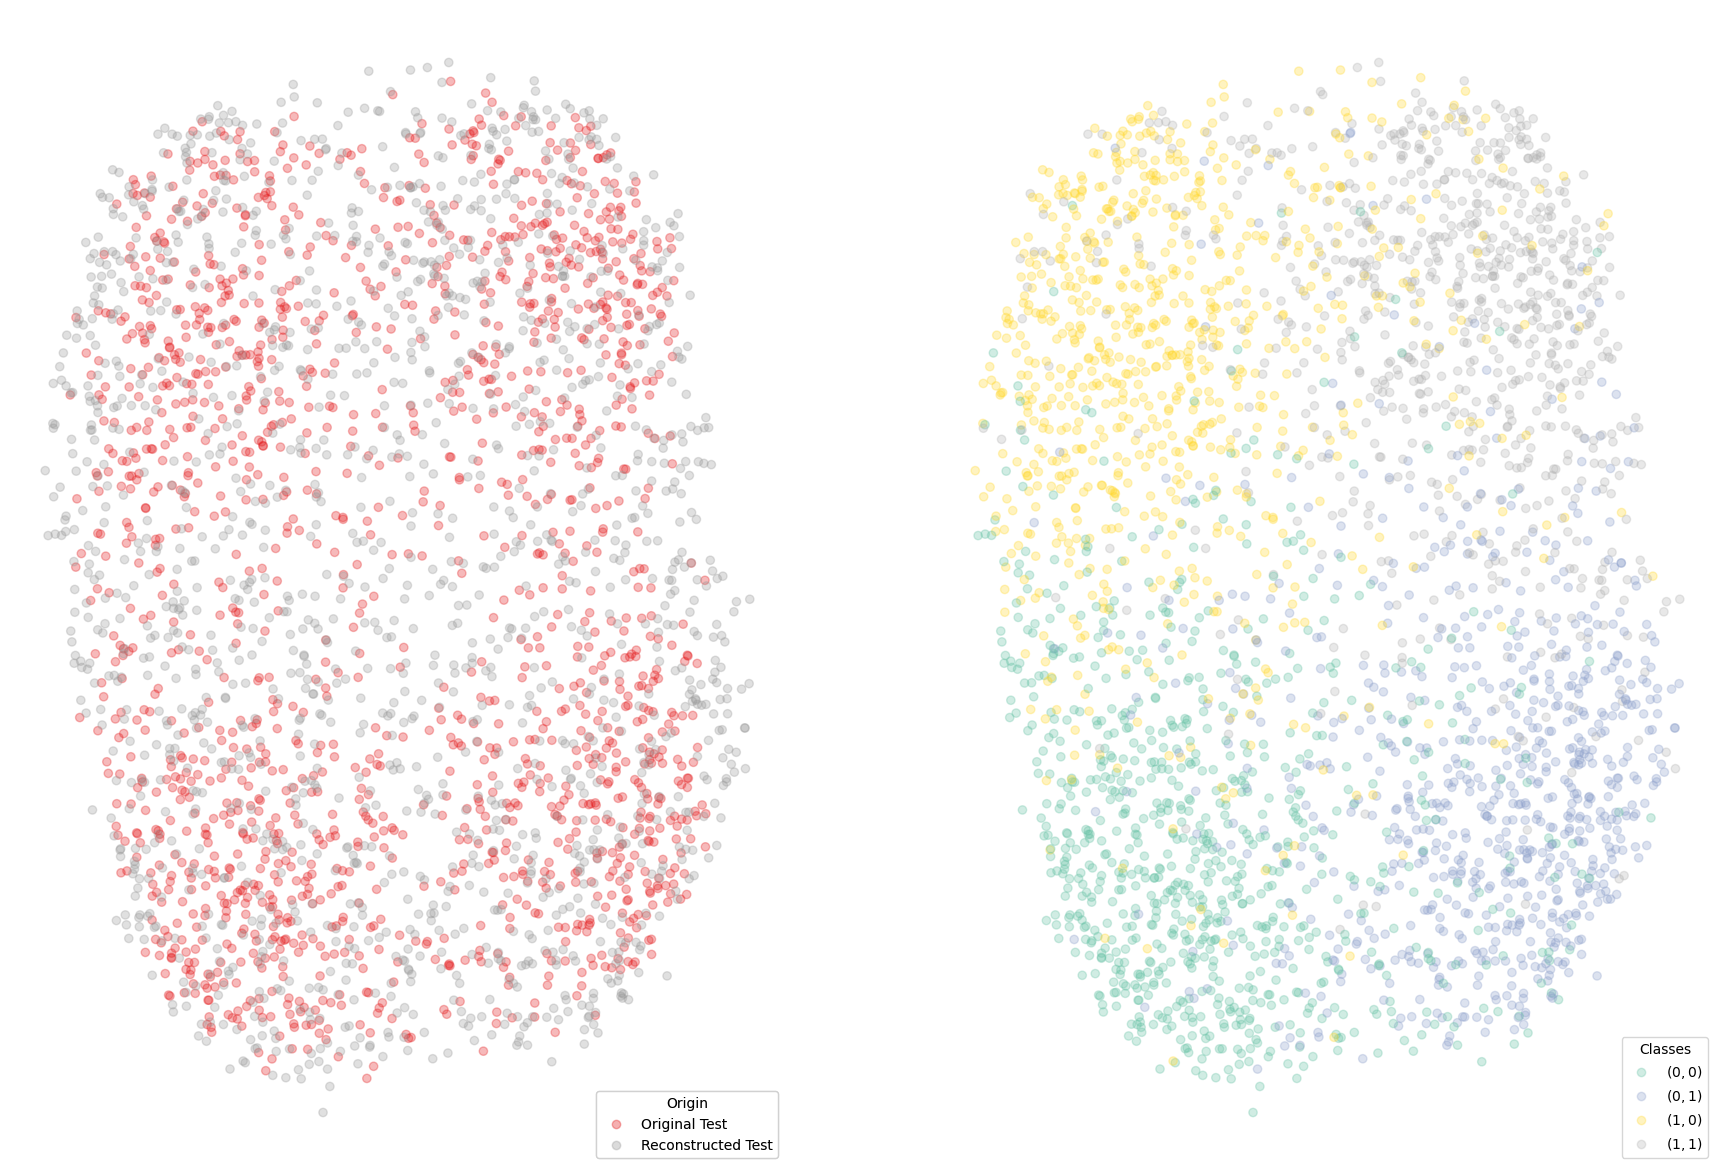

In [7]:
dat_t = predictive(test_set[:][0], test_set[:][1], test_set[:][1])["x"][0]

dat_tot = torch.concat((test_set[:][0], dat_t))
dat_tot_umap = reducer.fit_transform(dat_tot)

fig, ax = plt.subplots(1,2,figsize=(22,15), sharex=True, sharey=True)

scatter = ax[0].scatter(dat_tot_umap[:,0], dat_tot_umap[:,1], cmap="Set1", c= ([1]*len(test_set)) +([2]*len(test_set)), alpha=0.3)


elems = list(scatter.legend_elements())
elems[1] = [
 'Original Test',
  'Reconstructed Test']

legend = ax[0].legend(*elems, loc="lower right", title="Origin")
ax[0].add_artist(legend)

scatter = ax[1].scatter(dat_tot_umap[:,0], dat_tot_umap[:,1], cmap="Set2", c= get_labels(torch.concat((test_set[:][1], test_set[:][1]))).argmax(-1), alpha=0.3)


elems = list(scatter.legend_elements())
elems[1] = ['$\\mathdefault{(0,0)}$',
 '$\\mathdefault{(0,1)}$',
 '$\\mathdefault{(1,0)}$',
 '$\\mathdefault{(1,1)}$']

legend = ax[1].legend(*elems, loc="lower right", title="Classes")

ax[0].axis('off')
ax[1].axis('off')


#plt.savefig("reconstruction_check.png", dpi=300, bbox_inches="tight")

plt.show()

## Latent Components

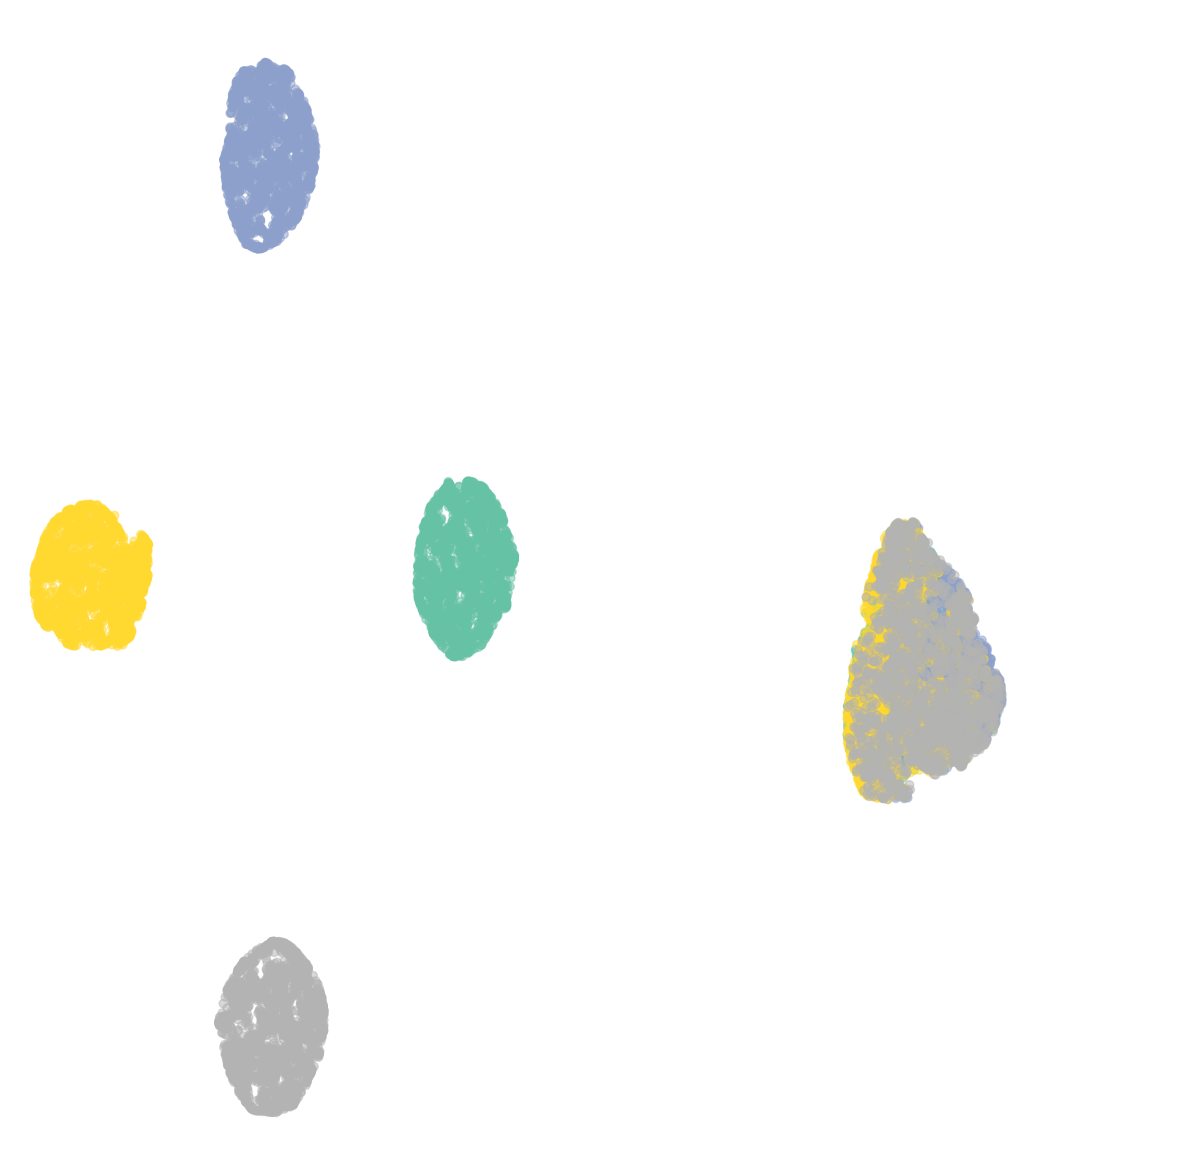

In [8]:
rho_latent = patches.rho_l_encoder(dataset[:][0])[0]
rho_y = _broadcast_inputs([rho_latent, dataset[:][1]])
rho_y = torch.cat(rho_y, dim=-1)


w_latent = patches.w_encoder(rho_y)[0]
z_latent = patches.z_encoder(rho_latent)[0]

data_w_mu = reducer.fit_transform(w_latent.detach().numpy())
data_z_mu = reducer.fit_transform(z_latent.detach().numpy())

fig, ax = plt.subplots(1,2,figsize=(15,15), sharex=True, sharey=True)

scatter = ax[0].scatter(data_w_mu[:,0], data_w_mu[:,1], c=np.array(get_labels(dataset[:][1]).argmax(-1)), cmap="Set2", alpha=0.5)
ax[1].scatter(data_z_mu[:,0], data_z_mu[:,1], c=np.array(get_labels(dataset[:][1]).argmax(-1)), cmap="Set2", alpha=0.5)



ax[0].axis('off')
ax[1].axis('off')

#ax[0].set_title('W - Conditional')
#ax[1].set_title('Z - Common')

#plt.savefig("latents_patches.png", dpi=300, bbox_inches="tight")

plt.show()